# The extended Rumelhart network in tensorflow 2.0 / keras

This notebook uses tensorflow 2.0 with Keras to implement the extended Rumelhart model of semantic cognition as described by Rogers and McClelland in the book *Semantic Cogntion: A Parallel Distributed Processing Approach*.

The model answers simple questions about the properties of animals and plants. There are 21 items in its world including four trees, four flowers, four birds, four fish, and five mammals. There are six questions that can be asked (general name, basic name, specific name, *is* properties, *can* properties, and *has* properties). One can think of the questions as providing a *task context* that indicates the *relationship* between the queried item and the properties to be retrieved. Given an item and relation query as input, the model must activate all of the properties that are both true of the item and of the correct relationship type.

## Imports to build and fit model

In [1]:
#For basic data types and functions
import numpy as np

#Tensorflow 
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate

#For visualization / analysis
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.manifold import MDS

In [2]:
from tensorflow.keras import backend as K

# Training patterns

There are 8 total items and 4 possible query relations making a total of 32 possible input/output patterns. Since the Item and Relation inputs get applied to two different layers, we will construct a numpy array for each, possessing 32 rows (32 input patterns) and columns equal to the number of units in each layer.

In [25]:
#Make one-hot array for item input patterns
tmp = K.one_hot(np.arange(0,21),21) #One-hot encoding of items
item_in_pats = tmp

tmp = K.one_hot(np.arange(0,21),21).numpy() #One-hot encodinbg of items

for _ in range(0,5):
    item_in_pats = np.append(item_in_pats, tmp, axis = 0)


#Make one-hot array for query input patterns    
tmp = np.zeros(21, dtype='uint8')
tmp1=tmp
for i in range(1,6):
        tmp1 = np.append(tmp1, tmp+i)
                         
query_in_pats  = K.one_hot(tmp1, 6).numpy()


#Read in output patterns
output_pats = np.genfromtxt('rumext_output_pats.csv', delimiter=',')
    

In [27]:
output_pats.shape

(126, 53)

In [5]:
#Labels for inputs, contexts

#item names:
inames = ['pine','oak','maple','birch','rose','daisy','daffodil','sunflower',
          'sunfish','salmon','flounder','cod','robin','canary','sparrow','penguin',
         'cat','dog','moude','goat','pig']

#query names:
qnames = ['gen_name','basic_name','spec_name', 'is','can','has']

#Attribute names
#attnames = ['Plant','Animal','Tree','Flower','Bird','Fish', 'Cat','Dog','Mouse','Goat','Pig'
#            'Pine','Oak','Rose','Daisy','Robin','Canary','Salmon', 'Sunfish',
#            'pretty','tall','living','green','red','yellow',
#            'grow','move','swim','fly','sing',
#            'bark','petals','wings','feathers','scales','gills','roots','skin'            
#           ]

## Parameters for model

Specify weight initialization parameters and optimizer parameters here.

In [6]:
#Parameterize distribution of initial weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -0.01, maxval = 0.01, seed = None)

#Select and parameterize the optimization algorithm:
opt = tf.keras.optimizers.SGD(learning_rate=0.05, nesterov = False, momentum = 0.0, decay = 0.0)


The initializer will set the starting weights to a sample from the specified uniform random distribution. It must be specified for both the receiving weights and the bias weights when the relevant layer is created. The optimizer chosen above replicates the original work---unvarnished gradient descent without momentum or decay.

## Build model

We will use the Keras API to build the model. Note the model has two input layers, with the first *Item* input connecting to the first hidden layer, and with the second input layer and the first hidden layer both connecting to the second hidden layer. The architecture is not just a single stack of layers, so we can't use the Sequential model type from Keras.

In [28]:
item_in = Input(shape=(21,)) #One-hot input representation of the item
cont_in = Input(shape=(6,)) #One-hot input representation for the query context

#Learned item representation (first hidden layer)
itemrep = Dense(15,activation='sigmoid',kernel_initializer=wt_init, bias_initializer=wt_init)(item_in) 

#Concatenate item representation and context input units
ir_and_cont = concatenate([itemrep, cont_in])    

#Connect concatenated layers to second hidden layer
contrep = Dense(28,activation='sigmoid', kernel_initializer=wt_init, bias_initializer=wt_init)(ir_and_cont)

#Connect to output attributes
attributes = Dense(53, activation='sigmoid', kernel_initializer=wt_init, bias_initializer=wt_init)(contrep)

#Construct model object called rumnet
rumext=Model(inputs=[item_in, cont_in], outputs=attributes)

print(rumext.summary()) #Check to make sure it looks right

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 15)           330         input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 21)           0           dense_9[0][0]                    
                                                                 input_8[0][0]              

## Compile model

WHile original work used squared error, experiments with the simple rumelhart model found analogous results with binary crossentropy error and the adam optimizer so I will use that here.

In [29]:
#Now compile it, specifying important parameters such as the loss and optimization algorithm
rumext.compile(optimizer='adam', loss='binary_crossentropy')

## Fit model

In [30]:
iwts = rumext.get_weights() #Store initial weights for later replication
H = rumext.fit(x=[item_in_pats, query_in_pats], y=output_pats, batch_size=126, epochs = 10000)

Train on 126 samples
Epoch 1/10000
126/126 [==============================] - 1s 11ms/sample - loss: 0.6945
Epoch 2/10000
126/126 [==============================] - 0s 99us/sample - loss: 0.6876
Epoch 3/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.6806
Epoch 4/10000
126/126 [==============================] - 0s 97us/sample - loss: 0.6737
Epoch 5/10000
126/126 [==============================] - 0s 117us/sample - loss: 0.6668
Epoch 6/10000
126/126 [==============================] - 0s 84us/sample - loss: 0.6599
Epoch 7/10000
126/126 [==============================] - 0s 86us/sample - loss: 0.6530
Epoch 8/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.6462
Epoch 9/10000
126/126 [==============================] - 0s 90us/sample - loss: 0.6393
Epoch 10/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.6324
Epoch 11/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.6256
Epoch 12/10000
126/

Epoch 94/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.2193
Epoch 95/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.2172
Epoch 96/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.2152
Epoch 97/10000
126/126 [==============================] - 0s 83us/sample - loss: 0.2133
Epoch 98/10000
126/126 [==============================] - 0s 83us/sample - loss: 0.2114
Epoch 99/10000
126/126 [==============================] - 0s 96us/sample - loss: 0.2096
Epoch 100/10000
126/126 [==============================] - 0s 134us/sample - loss: 0.2078
Epoch 101/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.2061
Epoch 102/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.2044
Epoch 103/10000
126/126 [==============================] - 0s 89us/sample - loss: 0.2028
Epoch 104/10000
126/126 [==============================] - 0s 107us/sample - loss: 0.2012
Epoch 105/10000
126/126 [

Epoch 186/10000
126/126 [==============================] - 0s 98us/sample - loss: 0.1470
Epoch 187/10000
126/126 [==============================] - 0s 88us/sample - loss: 0.1467
Epoch 188/10000
126/126 [==============================] - 0s 88us/sample - loss: 0.1465
Epoch 189/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.1463
Epoch 190/10000
126/126 [==============================] - 0s 143us/sample - loss: 0.1461
Epoch 191/10000
126/126 [==============================] - 0s 89us/sample - loss: 0.1459
Epoch 192/10000
126/126 [==============================] - 0s 100us/sample - loss: 0.1457
Epoch 193/10000
126/126 [==============================] - 0s 95us/sample - loss: 0.1455
Epoch 194/10000
126/126 [==============================] - 0s 117us/sample - loss: 0.1453
Epoch 195/10000
126/126 [==============================] - 0s 116us/sample - loss: 0.1451
Epoch 196/10000
126/126 [==============================] - 0s 90us/sample - loss: 0.1449
Epoch 197/10000
1

Epoch 278/10000
126/126 [==============================] - 0s 94us/sample - loss: 0.1365
Epoch 279/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1365
Epoch 280/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1364
Epoch 281/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1364
Epoch 282/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1363
Epoch 283/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.1363
Epoch 284/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1362
Epoch 285/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.1362
Epoch 286/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.1361
Epoch 287/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.1361
Epoch 288/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1360
Epoch 289/10000
126/1

126/126 [==============================] - 0s 57us/sample - loss: 0.1336
Epoch 371/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1336
Epoch 372/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.1336
Epoch 373/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1336
Epoch 374/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.1336
Epoch 375/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1335
Epoch 376/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1335
Epoch 377/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1335
Epoch 378/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.1335
Epoch 379/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1335
Epoch 380/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.1335
Epoch 381/10000
126/126 [============

Epoch 463/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1325
Epoch 464/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.1325
Epoch 465/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1325
Epoch 466/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.1325
Epoch 467/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1325
Epoch 468/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1325
Epoch 469/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.1325
Epoch 470/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1324
Epoch 471/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1324
Epoch 472/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.1324
Epoch 473/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1324
Epoch 474/10000
126/1

Epoch 555/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.1320
Epoch 556/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1320
Epoch 557/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1320
Epoch 558/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1320
Epoch 559/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.1320
Epoch 560/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1320
Epoch 561/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.1320
Epoch 562/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1319
Epoch 563/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1319
Epoch 564/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.1319
Epoch 565/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1319
Epoch 566/10000
126/1

126/126 [==============================] - 0s 84us/sample - loss: 0.1317
Epoch 648/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1317
Epoch 649/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.1317
Epoch 650/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1317
Epoch 651/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1317
Epoch 652/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.1317
Epoch 653/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1317
Epoch 654/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1317
Epoch 655/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1317
Epoch 656/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1317
Epoch 657/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.1317
Epoch 658/10000
126/126 [============

126/126 [==============================] - 0s 92us/sample - loss: 0.1315
Epoch 740/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.1315
Epoch 741/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.1315
Epoch 742/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.1315
Epoch 743/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1315
Epoch 744/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1315
Epoch 745/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1315
Epoch 746/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1315
Epoch 747/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1315
Epoch 748/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.1315
Epoch 749/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.1315
Epoch 750/10000
126/126 [============

Epoch 832/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.1313
Epoch 833/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.1313
Epoch 834/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1313
Epoch 835/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.1313
Epoch 836/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.1313
Epoch 837/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1313
Epoch 838/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1313
Epoch 839/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1313
Epoch 840/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.1313
Epoch 841/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1313
Epoch 842/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1313
Epoch 843/10000
126/1

Epoch 925/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1312
Epoch 926/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.1312
Epoch 927/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.1312
Epoch 928/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1312
Epoch 929/10000
126/126 [==============================] - 0s 30us/sample - loss: 0.1312
Epoch 930/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.1312
Epoch 931/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1312
Epoch 932/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1312
Epoch 933/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1312
Epoch 934/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.1312
Epoch 935/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.1312
Epoch 936/10000
126/1

Epoch 1017/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.1310
Epoch 1018/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.1310
Epoch 1019/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.1310
Epoch 1020/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1310
Epoch 1021/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.1310
Epoch 1022/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1310
Epoch 1023/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1310
Epoch 1024/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1310
Epoch 1025/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1310
Epoch 1026/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1310
Epoch 1027/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.1310
Epoch 1028

126/126 [==============================] - 0s 50us/sample - loss: 0.1308
Epoch 1109/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1308
Epoch 1110/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1308
Epoch 1111/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1308
Epoch 1112/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1308
Epoch 1113/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1308
Epoch 1114/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.1308
Epoch 1115/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1308
Epoch 1116/10000
126/126 [==============================] - 0s 90us/sample - loss: 0.1308
Epoch 1117/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.1308
Epoch 1118/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1308
Epoch 1119/10000
126/126 [=

Epoch 1200/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1306
Epoch 1201/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1306
Epoch 1202/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1306
Epoch 1203/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1306
Epoch 1204/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.1306
Epoch 1205/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1306
Epoch 1206/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.1306
Epoch 1207/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.1306
Epoch 1208/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1306
Epoch 1209/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1306
Epoch 1210/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1306
Epoch 1211

Epoch 1292/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1303
Epoch 1293/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.1303
Epoch 1294/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.1303
Epoch 1295/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1303
Epoch 1296/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1303
Epoch 1297/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.1303
Epoch 1298/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1303
Epoch 1299/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.1303
Epoch 1300/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.1303
Epoch 1301/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1303
Epoch 1302/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.1303
Epoch 1303

Epoch 1384/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.1300
Epoch 1385/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.1300
Epoch 1386/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.1300
Epoch 1387/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.1300
Epoch 1388/10000
126/126 [==============================] - 0s 36us/sample - loss: 0.1300
Epoch 1389/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.1300
Epoch 1390/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.1300
Epoch 1391/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1300
Epoch 1392/10000
126/126 [==============================] - 0s 36us/sample - loss: 0.1300
Epoch 1393/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1300
Epoch 1394/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.1300
Epoch 1395

Epoch 1476/10000
126/126 [==============================] - 0s 90us/sample - loss: 0.1297
Epoch 1477/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1297
Epoch 1478/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1297
Epoch 1479/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1297
Epoch 1480/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.1296
Epoch 1481/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1296
Epoch 1482/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1296
Epoch 1483/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1296
Epoch 1484/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.1296
Epoch 1485/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.1296
Epoch 1486/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.1296
Epoch 1487

126/126 [==============================] - 0s 64us/sample - loss: 0.1293
Epoch 1568/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1292
Epoch 1569/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.1292
Epoch 1570/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.1292
Epoch 1571/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1292
Epoch 1572/10000
126/126 [==============================] - 0s 89us/sample - loss: 0.1292
Epoch 1573/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.1292
Epoch 1574/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.1292
Epoch 1575/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.1292
Epoch 1576/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1292
Epoch 1577/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1292
Epoch 1578/10000
126/126 [=

Epoch 1659/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1288
Epoch 1660/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1288
Epoch 1661/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1287
Epoch 1662/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.1287
Epoch 1663/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.1287
Epoch 1664/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.1287
Epoch 1665/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.1287
Epoch 1666/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1287
Epoch 1667/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.1287
Epoch 1668/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1287
Epoch 1669/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.1287
Epoch 1670

Epoch 1751/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1281
Epoch 1752/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1281
Epoch 1753/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1281
Epoch 1754/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.1281
Epoch 1755/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.1281
Epoch 1756/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1281
Epoch 1757/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1280
Epoch 1758/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.1280
Epoch 1759/10000
126/126 [==============================] - 0s 93us/sample - loss: 0.1280
Epoch 1760/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.1280
Epoch 1761/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1280
Epoch 1762

126/126 [==============================] - 0s 47us/sample - loss: 0.1270
Epoch 1843/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.1270
Epoch 1844/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1270
Epoch 1845/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.1270
Epoch 1846/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.1270
Epoch 1847/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.1270
Epoch 1848/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.1270
Epoch 1849/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.1269
Epoch 1850/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1269
Epoch 1851/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.1269
Epoch 1852/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1269
Epoch 1853/10000
126/126 [=

Epoch 1934/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.1251
Epoch 1935/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.1251
Epoch 1936/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1251
Epoch 1937/10000
126/126 [==============================] - 0s 86us/sample - loss: 0.1251
Epoch 1938/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.1250
Epoch 1939/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.1250
Epoch 1940/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1250
Epoch 1941/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1250
Epoch 1942/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.1249
Epoch 1943/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.1249
Epoch 1944/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1249
Epoch 1945

Epoch 2026/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1218
Epoch 2027/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1218
Epoch 2028/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1218
Epoch 2029/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.1217
Epoch 2030/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1217
Epoch 2031/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.1216
Epoch 2032/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.1216
Epoch 2033/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.1215
Epoch 2034/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.1215
Epoch 2035/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1214
Epoch 2036/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.1214
Epoch 2037

126/126 [==============================] - 0s 53us/sample - loss: 0.1168
Epoch 2118/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.1168
Epoch 2119/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.1167
Epoch 2120/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.1166
Epoch 2121/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.1166
Epoch 2122/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.1165
Epoch 2123/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1164
Epoch 2124/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1164
Epoch 2125/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.1163
Epoch 2126/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.1162
Epoch 2127/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1162
Epoch 2128/10000
126/126 [=

Epoch 2209/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1103
Epoch 2210/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1102
Epoch 2211/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.1101
Epoch 2212/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.1100
Epoch 2213/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.1099
Epoch 2214/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.1099
Epoch 2215/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.1098
Epoch 2216/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.1097
Epoch 2217/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.1096
Epoch 2218/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.1096
Epoch 2219/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.1095
Epoch 2220

Epoch 2301/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.1034
Epoch 2302/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.1033
Epoch 2303/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.1032
Epoch 2304/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.1032
Epoch 2305/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.1031
Epoch 2306/10000
126/126 [==============================] - 0s 85us/sample - loss: 0.1030
Epoch 2307/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.1029
Epoch 2308/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.1029
Epoch 2309/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.1028
Epoch 2310/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.1027
Epoch 2311/10000
126/126 [==============================] - 0s 88us/sample - loss: 0.1027
Epoch 2312

Epoch 2393/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0974
Epoch 2394/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0973
Epoch 2395/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0972
Epoch 2396/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0972
Epoch 2397/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0971
Epoch 2398/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0971
Epoch 2399/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0970
Epoch 2400/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0970
Epoch 2401/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0969
Epoch 2402/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0968
Epoch 2403/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0968
Epoch 2404

Epoch 2485/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0925
Epoch 2486/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0925
Epoch 2487/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0924
Epoch 2488/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0924
Epoch 2489/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0923
Epoch 2490/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0923
Epoch 2491/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0923
Epoch 2492/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0922
Epoch 2493/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0922
Epoch 2494/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0921
Epoch 2495/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0921
Epoch 2496

126/126 [==============================] - 0s 69us/sample - loss: 0.0887
Epoch 2577/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0886
Epoch 2578/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0886
Epoch 2579/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0886
Epoch 2580/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0885
Epoch 2581/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0885
Epoch 2582/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0885
Epoch 2583/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0884
Epoch 2584/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0884
Epoch 2585/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0883
Epoch 2586/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0883
Epoch 2587/10000
126/126 [=

Epoch 2668/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0855
Epoch 2669/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0855
Epoch 2670/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0854
Epoch 2671/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0854
Epoch 2672/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0854
Epoch 2673/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0853
Epoch 2674/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0853
Epoch 2675/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0853
Epoch 2676/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0852
Epoch 2677/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0852
Epoch 2678/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0852
Epoch 2679

126/126 [==============================] - 0s 45us/sample - loss: 0.0828
Epoch 2760/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0828
Epoch 2761/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0828
Epoch 2762/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0828
Epoch 2763/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0827
Epoch 2764/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.0827
Epoch 2765/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0827
Epoch 2766/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0826
Epoch 2767/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0826
Epoch 2768/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0826
Epoch 2769/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0826
Epoch 2770/10000
126/126 [=

Epoch 2851/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0806
Epoch 2852/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0805
Epoch 2853/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0805
Epoch 2854/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0805
Epoch 2855/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0805
Epoch 2856/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0804
Epoch 2857/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0804
Epoch 2858/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0804
Epoch 2859/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0804
Epoch 2860/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0804
Epoch 2861/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0803
Epoch 2862

Epoch 2943/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0786
Epoch 2944/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0786
Epoch 2945/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0786
Epoch 2946/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0786
Epoch 2947/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0786
Epoch 2948/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0785
Epoch 2949/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0785
Epoch 2950/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0785
Epoch 2951/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0785
Epoch 2952/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0785
Epoch 2953/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0784
Epoch 2954

126/126 [==============================] - 0s 88us/sample - loss: 0.0770
Epoch 3035/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0770
Epoch 3036/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0770
Epoch 3037/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0770
Epoch 3038/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0769
Epoch 3039/10000
126/126 [==============================] - 0s 83us/sample - loss: 0.0769
Epoch 3040/10000
126/126 [==============================] - 0s 84us/sample - loss: 0.0769
Epoch 3041/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0769
Epoch 3042/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0769
Epoch 3043/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0769
Epoch 3044/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0768
Epoch 3045/10000
126/126 [=

126/126 [==============================] - 0s 43us/sample - loss: 0.0756
Epoch 3126/10000
126/126 [==============================] - 0s 218us/sample - loss: 0.0756
Epoch 3127/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0755
Epoch 3128/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0755
Epoch 3129/10000
126/126 [==============================] - 0s 31us/sample - loss: 0.0755
Epoch 3130/10000
126/126 [==============================] - 0s 33us/sample - loss: 0.0755
Epoch 3131/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0755
Epoch 3132/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.0755
Epoch 3133/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0754
Epoch 3134/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0754
Epoch 3135/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0754
Epoch 3136/10000
126/126 [

Epoch 3217/10000
126/126 [==============================] - 0s 87us/sample - loss: 0.0742
Epoch 3218/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0742
Epoch 3219/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.0742
Epoch 3220/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0742
Epoch 3221/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0742
Epoch 3222/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0742
Epoch 3223/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0742
Epoch 3224/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0741
Epoch 3225/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0741
Epoch 3226/10000
126/126 [==============================] - 0s 85us/sample - loss: 0.0741
Epoch 3227/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0741
Epoch 3228

Epoch 3309/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0730
Epoch 3310/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0730
Epoch 3311/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0729
Epoch 3312/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0729
Epoch 3313/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0729
Epoch 3314/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0729
Epoch 3315/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0729
Epoch 3316/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0729
Epoch 3317/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0729
Epoch 3318/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0729
Epoch 3319/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0728
Epoch 3320

126/126 [==============================] - 0s 64us/sample - loss: 0.0717
Epoch 3401/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0717
Epoch 3402/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0717
Epoch 3403/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0717
Epoch 3404/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0717
Epoch 3405/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0717
Epoch 3406/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0717
Epoch 3407/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0716
Epoch 3408/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0716
Epoch 3409/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0716
Epoch 3410/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0716
Epoch 3411/10000
126/126 [=

Epoch 3492/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0705
Epoch 3493/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0705
Epoch 3494/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0704
Epoch 3495/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0704
Epoch 3496/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0704
Epoch 3497/10000
126/126 [==============================] - 0s 87us/sample - loss: 0.0704
Epoch 3498/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0704
Epoch 3499/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0704
Epoch 3500/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0704
Epoch 3501/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0704
Epoch 3502/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0703
Epoch 3503

126/126 [==============================] - 0s 63us/sample - loss: 0.0692
Epoch 3584/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0692
Epoch 3585/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0692
Epoch 3586/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0692
Epoch 3587/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0691
Epoch 3588/10000
126/126 [==============================] - 0s 25us/sample - loss: 0.0691
Epoch 3589/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0691
Epoch 3590/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0691
Epoch 3591/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0691
Epoch 3592/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0691
Epoch 3593/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0691
Epoch 3594/10000
126/126 [=

Epoch 3675/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0679
Epoch 3676/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0679
Epoch 3677/10000
126/126 [==============================] - 0s 87us/sample - loss: 0.0678
Epoch 3678/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0678
Epoch 3679/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0678
Epoch 3680/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0678
Epoch 3681/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0678
Epoch 3682/10000
126/126 [==============================] - 0s 84us/sample - loss: 0.0678
Epoch 3683/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0678
Epoch 3684/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0677
Epoch 3685/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0677
Epoch 3686

Epoch 3766/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0665
Epoch 3767/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0665
Epoch 3768/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0665
Epoch 3769/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0665
Epoch 3770/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0665
Epoch 3771/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0665
Epoch 3772/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0664
Epoch 3773/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0664
Epoch 3774/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0664
Epoch 3775/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0664
Epoch 3776/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.0664
Epoch 3777

Epoch 3858/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0651
Epoch 3859/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0650
Epoch 3860/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0650
Epoch 3861/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0650
Epoch 3862/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0650
Epoch 3863/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0650
Epoch 3864/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0650
Epoch 3865/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0649
Epoch 3866/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0649
Epoch 3867/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0649
Epoch 3868/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0649
Epoch 3869

126/126 [==============================] - 0s 63us/sample - loss: 0.0633
Epoch 3950/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0633
Epoch 3951/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0632
Epoch 3952/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0632
Epoch 3953/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0632
Epoch 3954/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0632
Epoch 3955/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0632
Epoch 3956/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0631
Epoch 3957/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0631
Epoch 3958/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0631
Epoch 3959/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0631
Epoch 3960/10000
126/126 [=

Epoch 4041/10000
126/126 [==============================] - 0s 104us/sample - loss: 0.0609
Epoch 4042/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0609
Epoch 4043/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0609
Epoch 4044/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0608
Epoch 4045/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0608
Epoch 4046/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0608
Epoch 4047/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0607
Epoch 4048/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0607
Epoch 4049/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0607
Epoch 4050/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0607
Epoch 4051/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0606
Epoch 405

126/126 [==============================] - 0s 54us/sample - loss: 0.0580
Epoch 4133/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0580
Epoch 4134/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0580
Epoch 4135/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0579
Epoch 4136/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0579
Epoch 4137/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0579
Epoch 4138/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0578
Epoch 4139/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0578
Epoch 4140/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0578
Epoch 4141/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0577
Epoch 4142/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0577
Epoch 4143/10000
126/126 [=

Epoch 4224/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0550
Epoch 4225/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0550
Epoch 4226/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0550
Epoch 4227/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0549
Epoch 4228/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0549
Epoch 4229/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0549
Epoch 4230/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0548
Epoch 4231/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0548
Epoch 4232/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0548
Epoch 4233/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0547
Epoch 4234/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0547
Epoch 4235

126/126 [==============================] - 0s 55us/sample - loss: 0.0524
Epoch 4316/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0523
Epoch 4317/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0523
Epoch 4318/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0523
Epoch 4319/10000
126/126 [==============================] - 0s 79us/sample - loss: 0.0523
Epoch 4320/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0522
Epoch 4321/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0522
Epoch 4322/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0522
Epoch 4323/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0522
Epoch 4324/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0521
Epoch 4325/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0521
Epoch 4326/10000
126/126 [=

Epoch 4407/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0502
Epoch 4408/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0502
Epoch 4409/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0501
Epoch 4410/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0501
Epoch 4411/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0501
Epoch 4412/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0501
Epoch 4413/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0500
Epoch 4414/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0500
Epoch 4415/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0500
Epoch 4416/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0500
Epoch 4417/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0500
Epoch 4418

Epoch 4499/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0484
Epoch 4500/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0484
Epoch 4501/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0484
Epoch 4502/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0484
Epoch 4503/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0483
Epoch 4504/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0483
Epoch 4505/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0483
Epoch 4506/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0483
Epoch 4507/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0483
Epoch 4508/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0483
Epoch 4509/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0482
Epoch 4510

126/126 [==============================] - 0s 61us/sample - loss: 0.0470
Epoch 4591/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0470
Epoch 4592/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0470
Epoch 4593/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0469
Epoch 4594/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0469
Epoch 4595/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0469
Epoch 4596/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0469
Epoch 4597/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0469
Epoch 4598/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0469
Epoch 4599/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0469
Epoch 4600/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0468
Epoch 4601/10000
126/126 [=

Epoch 4682/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0458
Epoch 4683/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0457
Epoch 4684/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0457
Epoch 4685/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0457
Epoch 4686/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0457
Epoch 4687/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0457
Epoch 4688/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0457
Epoch 4689/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0457
Epoch 4690/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0457
Epoch 4691/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0456
Epoch 4692/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0456
Epoch 4693

126/126 [==============================] - 0s 88us/sample - loss: 0.0447
Epoch 4774/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0447
Epoch 4775/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0447
Epoch 4776/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0447
Epoch 4777/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0447
Epoch 4778/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0446
Epoch 4779/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0446
Epoch 4780/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0446
Epoch 4781/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0446
Epoch 4782/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0446
Epoch 4783/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0446
Epoch 4784/10000
126/126 [=

Epoch 4865/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0437
Epoch 4866/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0437
Epoch 4867/10000
126/126 [==============================] - 0s 86us/sample - loss: 0.0437
Epoch 4868/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0437
Epoch 4869/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0437
Epoch 4870/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0437
Epoch 4871/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0437
Epoch 4872/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0437
Epoch 4873/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0437
Epoch 4874/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0437
Epoch 4875/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0436
Epoch 4876

Epoch 4957/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0429
Epoch 4958/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0429
Epoch 4959/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0429
Epoch 4960/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0428
Epoch 4961/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0428
Epoch 4962/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0428
Epoch 4963/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.0428
Epoch 4964/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0428
Epoch 4965/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0428
Epoch 4966/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0428
Epoch 4967/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0428
Epoch 4968

126/126 [==============================] - 0s 63us/sample - loss: 0.0421
Epoch 5049/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0421
Epoch 5050/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0420
Epoch 5051/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0420
Epoch 5052/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0420
Epoch 5053/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0420
Epoch 5054/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0420
Epoch 5055/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0420
Epoch 5056/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0420
Epoch 5057/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0420
Epoch 5058/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0420
Epoch 5059/10000
126/126 [=

Epoch 5140/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0413
Epoch 5141/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0413
Epoch 5142/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0413
Epoch 5143/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0413
Epoch 5144/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0413
Epoch 5145/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0413
Epoch 5146/10000
126/126 [==============================] - 0s 79us/sample - loss: 0.0412
Epoch 5147/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0412
Epoch 5148/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0412
Epoch 5149/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0412
Epoch 5150/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0412
Epoch 5151

Epoch 5232/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0406
Epoch 5233/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0405
Epoch 5234/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0405
Epoch 5235/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.0405
Epoch 5236/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0405
Epoch 5237/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0405
Epoch 5238/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0405
Epoch 5239/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0405
Epoch 5240/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0405
Epoch 5241/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0405
Epoch 5242/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0405
Epoch 5243

126/126 [==============================] - 0s 71us/sample - loss: 0.0398
Epoch 5324/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0398
Epoch 5325/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0398
Epoch 5326/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0398
Epoch 5327/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0398
Epoch 5328/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0398
Epoch 5329/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0398
Epoch 5330/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0398
Epoch 5331/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0398
Epoch 5332/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0398
Epoch 5333/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0398
Epoch 5334/10000
126/126 [=

Epoch 5415/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0391
Epoch 5416/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0391
Epoch 5417/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0391
Epoch 5418/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0391
Epoch 5419/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.0391
Epoch 5420/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0391
Epoch 5421/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0391
Epoch 5422/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0391
Epoch 5423/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0390
Epoch 5424/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0390
Epoch 5425/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0390
Epoch 5426

126/126 [==============================] - 0s 66us/sample - loss: 0.0384
Epoch 5507/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0384
Epoch 5508/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0384
Epoch 5509/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0384
Epoch 5510/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0384
Epoch 5511/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0384
Epoch 5512/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0383
Epoch 5513/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0383
Epoch 5514/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0383
Epoch 5515/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0383
Epoch 5516/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0383
Epoch 5517/10000
126/126 [=

Epoch 5598/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0377
Epoch 5599/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0376
Epoch 5600/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0376
Epoch 5601/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0376
Epoch 5602/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0376
Epoch 5603/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0376
Epoch 5604/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0376
Epoch 5605/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0376
Epoch 5606/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0376
Epoch 5607/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0376
Epoch 5608/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0376
Epoch 5609

Epoch 5690/10000
126/126 [==============================] - 0s 85us/sample - loss: 0.0369
Epoch 5691/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0369
Epoch 5692/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0369
Epoch 5693/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0369
Epoch 5694/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0369
Epoch 5695/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0369
Epoch 5696/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0369
Epoch 5697/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0368
Epoch 5698/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0368
Epoch 5699/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0368
Epoch 5700/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0368
Epoch 5701

Epoch 5782/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0361
Epoch 5783/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0361
Epoch 5784/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0361
Epoch 5785/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0361
Epoch 5786/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0361
Epoch 5787/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0361
Epoch 5788/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0361
Epoch 5789/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0361
Epoch 5790/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0361
Epoch 5791/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0361
Epoch 5792/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0361
Epoch 5793

126/126 [==============================] - 0s 63us/sample - loss: 0.0354
Epoch 5874/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0354
Epoch 5875/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0354
Epoch 5876/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0353
Epoch 5877/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0353
Epoch 5878/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0353
Epoch 5879/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0353
Epoch 5880/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0353
Epoch 5881/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0353
Epoch 5882/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0353
Epoch 5883/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0353
Epoch 5884/10000
126/126 [=

Epoch 5965/10000
126/126 [==============================] - 0s 86us/sample - loss: 0.0346
Epoch 5966/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0346
Epoch 5967/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0346
Epoch 5968/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0346
Epoch 5969/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0346
Epoch 5970/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0346
Epoch 5971/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0345
Epoch 5972/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0345
Epoch 5973/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0345
Epoch 5974/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0345
Epoch 5975/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0345
Epoch 5976

126/126 [==============================] - 0s 79us/sample - loss: 0.0338
Epoch 6057/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0338
Epoch 6058/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0338
Epoch 6059/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0338
Epoch 6060/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0338
Epoch 6061/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0338
Epoch 6062/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0338
Epoch 6063/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0338
Epoch 6064/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0337
Epoch 6065/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0337
Epoch 6066/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0337
Epoch 6067/10000
126/126 [=

Epoch 6148/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0330
Epoch 6149/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0330
Epoch 6150/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0330
Epoch 6151/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0330
Epoch 6152/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0330
Epoch 6153/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0330
Epoch 6154/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0329
Epoch 6155/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0329
Epoch 6156/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0329
Epoch 6157/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0329
Epoch 6158/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0329
Epoch 6159

126/126 [==============================] - 0s 72us/sample - loss: 0.0322
Epoch 6240/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0321
Epoch 6241/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0321
Epoch 6242/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0321
Epoch 6243/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0321
Epoch 6244/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0321
Epoch 6245/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0321
Epoch 6246/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0321
Epoch 6247/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0321
Epoch 6248/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0321
Epoch 6249/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0321
Epoch 6250/10000
126/126 [=

Epoch 6331/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0312
Epoch 6332/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0312
Epoch 6333/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0312
Epoch 6334/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0312
Epoch 6335/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0312
Epoch 6336/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0312
Epoch 6337/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0312
Epoch 6338/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0311
Epoch 6339/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0311
Epoch 6340/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0311
Epoch 6341/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0311
Epoch 6342

126/126 [==============================] - 0s 49us/sample - loss: 0.0302
Epoch 6423/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0301
Epoch 6424/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0301
Epoch 6425/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0301
Epoch 6426/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0301
Epoch 6427/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0301
Epoch 6428/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0301
Epoch 6429/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0301
Epoch 6430/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0301
Epoch 6431/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0300
Epoch 6432/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0300
Epoch 6433/10000
126/126 [=

Epoch 6514/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0289
Epoch 6515/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0289
Epoch 6516/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0289
Epoch 6517/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0289
Epoch 6518/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0289
Epoch 6519/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0288
Epoch 6520/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0288
Epoch 6521/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0288
Epoch 6522/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0288
Epoch 6523/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.0288
Epoch 6524/10000
126/126 [==============================] - 0s 89us/sample - loss: 0.0288
Epoch 6525

126/126 [==============================] - 0s 44us/sample - loss: 0.0275
Epoch 6606/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0275
Epoch 6607/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0275
Epoch 6608/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0274
Epoch 6609/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0274
Epoch 6610/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0274
Epoch 6611/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0274
Epoch 6612/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0274
Epoch 6613/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0273
Epoch 6614/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0273
Epoch 6615/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0273
Epoch 6616/10000
126/126 [=

Epoch 6697/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0258
Epoch 6698/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0258
Epoch 6699/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0258
Epoch 6700/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0258
Epoch 6701/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0258
Epoch 6702/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0258
Epoch 6703/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0257
Epoch 6704/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0257
Epoch 6705/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0257
Epoch 6706/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0257
Epoch 6707/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0257
Epoch 6708

Epoch 6789/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0242
Epoch 6790/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0242
Epoch 6791/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0241
Epoch 6792/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0241
Epoch 6793/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0241
Epoch 6794/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0241
Epoch 6795/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0241
Epoch 6796/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0240
Epoch 6797/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0240
Epoch 6798/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0240
Epoch 6799/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0240
Epoch 6800

Epoch 6880/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0226
Epoch 6881/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0226
Epoch 6882/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0226
Epoch 6883/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0226
Epoch 6884/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0226
Epoch 6885/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0225
Epoch 6886/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0225
Epoch 6887/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0225
Epoch 6888/10000
126/126 [==============================] - 0s 78us/sample - loss: 0.0225
Epoch 6889/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0225
Epoch 6890/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0225
Epoch 6891

126/126 [==============================] - 0s 64us/sample - loss: 0.0212
Epoch 6972/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0212
Epoch 6973/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0212
Epoch 6974/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0212
Epoch 6975/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0212
Epoch 6976/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0212
Epoch 6977/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0212
Epoch 6978/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0211
Epoch 6979/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0211
Epoch 6980/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0211
Epoch 6981/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0211
Epoch 6982/10000
126/126 [=

126/126 [==============================] - 0s 64us/sample - loss: 0.0200
Epoch 7063/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0200
Epoch 7064/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0200
Epoch 7065/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0200
Epoch 7066/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0200
Epoch 7067/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0200
Epoch 7068/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0200
Epoch 7069/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0199
Epoch 7070/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0199
Epoch 7071/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0199
Epoch 7072/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0199
Epoch 7073/10000
126/126 [=

Epoch 7154/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0189
Epoch 7155/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0189
Epoch 7156/10000
126/126 [==============================] - 0s 85us/sample - loss: 0.0189
Epoch 7157/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0189
Epoch 7158/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0189
Epoch 7159/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0189
Epoch 7160/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0189
Epoch 7161/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0189
Epoch 7162/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0189
Epoch 7163/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0188
Epoch 7164/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0188
Epoch 7165

Epoch 7246/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0180
Epoch 7247/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0180
Epoch 7248/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0179
Epoch 7249/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0179
Epoch 7250/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0179
Epoch 7251/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0179
Epoch 7252/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0179
Epoch 7253/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0179
Epoch 7254/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0179
Epoch 7255/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0179
Epoch 7256/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0179
Epoch 7257

126/126 [==============================] - 0s 76us/sample - loss: 0.0171
Epoch 7338/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0171
Epoch 7339/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0171
Epoch 7340/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0171
Epoch 7341/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0171
Epoch 7342/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0170
Epoch 7343/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0170
Epoch 7344/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0170
Epoch 7345/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0170
Epoch 7346/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0170
Epoch 7347/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0170
Epoch 7348/10000
126/126 [=

Epoch 7429/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0163
Epoch 7430/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0163
Epoch 7431/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0163
Epoch 7432/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0163
Epoch 7433/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0162
Epoch 7434/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0162
Epoch 7435/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0162
Epoch 7436/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0162
Epoch 7437/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0162
Epoch 7438/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0162
Epoch 7439/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0162
Epoch 7440

Epoch 7521/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0155
Epoch 7522/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0155
Epoch 7523/10000
126/126 [==============================] - 0s 76us/sample - loss: 0.0155
Epoch 7524/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0155
Epoch 7525/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0155
Epoch 7526/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0155
Epoch 7527/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0155
Epoch 7528/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0155
Epoch 7529/10000
126/126 [==============================] - 0s 102us/sample - loss: 0.0155
Epoch 7530/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0154
Epoch 7531/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0154
Epoch 753

Epoch 7612/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0148
Epoch 7613/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0148
Epoch 7614/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0148
Epoch 7615/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0148
Epoch 7616/10000
126/126 [==============================] - 0s 36us/sample - loss: 0.0148
Epoch 7617/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0148
Epoch 7618/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0148
Epoch 7619/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.0148
Epoch 7620/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0148
Epoch 7621/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0147
Epoch 7622/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0147
Epoch 7623

Epoch 7703/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0141
Epoch 7704/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0141
Epoch 7705/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0141
Epoch 7706/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0141
Epoch 7707/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0141
Epoch 7708/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0141
Epoch 7709/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0141
Epoch 7710/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0141
Epoch 7711/10000
126/126 [==============================] - 0s 36us/sample - loss: 0.0141
Epoch 7712/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0141
Epoch 7713/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0141
Epoch 7714

126/126 [==============================] - 0s 33us/sample - loss: 0.0135
Epoch 7795/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0135
Epoch 7796/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0135
Epoch 7797/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0135
Epoch 7798/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0135
Epoch 7799/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0135
Epoch 7800/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0135
Epoch 7801/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0135
Epoch 7802/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0134
Epoch 7803/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0134
Epoch 7804/10000
126/126 [==============================] - 0s 29us/sample - loss: 0.0134
Epoch 7805/10000
126/126 [=

Epoch 7886/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0129
Epoch 7887/10000
126/126 [==============================] - 0s 35us/sample - loss: 0.0129
Epoch 7888/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.0129
Epoch 7889/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0128
Epoch 7890/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0128
Epoch 7891/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0128
Epoch 7892/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0128
Epoch 7893/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0128
Epoch 7894/10000
126/126 [==============================] - 0s 30us/sample - loss: 0.0128
Epoch 7895/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0128
Epoch 7896/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0128
Epoch 7897

126/126 [==============================] - 0s 38us/sample - loss: 0.0122
Epoch 7978/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0122
Epoch 7979/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0122
Epoch 7980/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0122
Epoch 7981/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0122
Epoch 7982/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0122
Epoch 7983/10000
126/126 [==============================] - 0s 33us/sample - loss: 0.0122
Epoch 7984/10000
126/126 [==============================] - 0s 31us/sample - loss: 0.0122
Epoch 7985/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0122
Epoch 7986/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0122
Epoch 7987/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0122
Epoch 7988/10000
126/126 [=

Epoch 8069/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0116
Epoch 8070/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0116
Epoch 8071/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0116
Epoch 8072/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0116
Epoch 8073/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0116
Epoch 8074/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0116
Epoch 8075/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.0116
Epoch 8076/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0116
Epoch 8077/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0116
Epoch 8078/10000
126/126 [==============================] - 0s 30us/sample - loss: 0.0116
Epoch 8079/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0115
Epoch 8080

126/126 [==============================] - 0s 53us/sample - loss: 0.0110
Epoch 8161/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0110
Epoch 8162/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0110
Epoch 8163/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0110
Epoch 8164/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.0110
Epoch 8165/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0110
Epoch 8166/10000
126/126 [==============================] - 0s 34us/sample - loss: 0.0110
Epoch 8167/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0110
Epoch 8168/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0110
Epoch 8169/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0110
Epoch 8170/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0109
Epoch 8171/10000
126/126 [=

Epoch 8252/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0104
Epoch 8253/10000
126/126 [==============================] - 0s 35us/sample - loss: 0.0104
Epoch 8254/10000
126/126 [==============================] - 0s 39us/sample - loss: 0.0104
Epoch 8255/10000
126/126 [==============================] - 0s 23us/sample - loss: 0.0104
Epoch 8256/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0104
Epoch 8257/10000
126/126 [==============================] - 0s 31us/sample - loss: 0.0104
Epoch 8258/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0104
Epoch 8259/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0104
Epoch 8260/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0104
Epoch 8261/10000
126/126 [==============================] - 0s 30us/sample - loss: 0.0104
Epoch 8262/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0103
Epoch 8263

126/126 [==============================] - 0s 32us/sample - loss: 0.0098
Epoch 8344/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0098
Epoch 8345/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0098
Epoch 8346/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0098
Epoch 8347/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0098
Epoch 8348/10000
126/126 [==============================] - 0s 75us/sample - loss: 0.0098
Epoch 8349/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0098
Epoch 8350/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0098
Epoch 8351/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0098
Epoch 8352/10000
126/126 [==============================] - 0s 37us/sample - loss: 0.0098
Epoch 8353/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0098
Epoch 8354/10000
126/126 [=

Epoch 8435/10000
126/126 [==============================] - 0s 38us/sample - loss: 0.0093
Epoch 8436/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0092
Epoch 8437/10000
126/126 [==============================] - 0s 30us/sample - loss: 0.0092
Epoch 8438/10000
126/126 [==============================] - 0s 46us/sample - loss: 0.0092
Epoch 8439/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0092
Epoch 8440/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0092
Epoch 8441/10000
126/126 [==============================] - 0s 29us/sample - loss: 0.0092
Epoch 8442/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0092
Epoch 8443/10000
126/126 [==============================] - 0s 32us/sample - loss: 0.0092
Epoch 8444/10000
126/126 [==============================] - 0s 40us/sample - loss: 0.0092
Epoch 8445/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0092
Epoch 8446

126/126 [==============================] - 0s 53us/sample - loss: 0.0087
Epoch 8527/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0087
Epoch 8528/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0087
Epoch 8529/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0087
Epoch 8530/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0087
Epoch 8531/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0087
Epoch 8532/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0087
Epoch 8533/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0087
Epoch 8534/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0087
Epoch 8535/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0087
Epoch 8536/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0086
Epoch 8537/10000
126/126 [=

Epoch 8618/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0082
Epoch 8619/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0082
Epoch 8620/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0081
Epoch 8621/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0081
Epoch 8622/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0081
Epoch 8623/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0081
Epoch 8624/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0081
Epoch 8625/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0081
Epoch 8626/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0081
Epoch 8627/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0081
Epoch 8628/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0081
Epoch 8629

Epoch 8710/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0076
Epoch 8711/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0076
Epoch 8712/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0076
Epoch 8713/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0076
Epoch 8714/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0076
Epoch 8715/10000
126/126 [==============================] - 0s 81us/sample - loss: 0.0076
Epoch 8716/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0076
Epoch 8717/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0076
Epoch 8718/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0076
Epoch 8719/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0076
Epoch 8720/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0076
Epoch 8721

Epoch 8802/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0071
Epoch 8803/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0071
Epoch 8804/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0071
Epoch 8805/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0071
Epoch 8806/10000
126/126 [==============================] - 0s 44us/sample - loss: 0.0071
Epoch 8807/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0071
Epoch 8808/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0071
Epoch 8809/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0071
Epoch 8810/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0071
Epoch 8811/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0071
Epoch 8812/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0070
Epoch 8813

Epoch 8894/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0066
Epoch 8895/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0066
Epoch 8896/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0066
Epoch 8897/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0066
Epoch 8898/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0066
Epoch 8899/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0066
Epoch 8900/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0066
Epoch 8901/10000
126/126 [==============================] - 0s 41us/sample - loss: 0.0066
Epoch 8902/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0066
Epoch 8903/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0066
Epoch 8904/10000
126/126 [==============================] - 0s 80us/sample - loss: 0.0066
Epoch 8905

126/126 [==============================] - 0s 70us/sample - loss: 0.0061
Epoch 8986/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0061
Epoch 8987/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0061
Epoch 8988/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0061
Epoch 8989/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0061
Epoch 8990/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0061
Epoch 8991/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0061
Epoch 8992/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0061
Epoch 8993/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0061
Epoch 8994/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0061
Epoch 8995/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0061
Epoch 8996/10000
126/126 [=

Epoch 9077/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0057
Epoch 9078/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0057
Epoch 9079/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0057
Epoch 9080/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0057
Epoch 9081/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0057
Epoch 9082/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0057
Epoch 9083/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0057
Epoch 9084/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0057
Epoch 9085/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0057
Epoch 9086/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0057
Epoch 9087/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0056
Epoch 9088

126/126 [==============================] - 0s 58us/sample - loss: 0.0053
Epoch 9169/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0053
Epoch 9170/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0053
Epoch 9171/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0053
Epoch 9172/10000
126/126 [==============================] - 0s 47us/sample - loss: 0.0053
Epoch 9173/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0053
Epoch 9174/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0053
Epoch 9175/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0053
Epoch 9176/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0053
Epoch 9177/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0053
Epoch 9178/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0052
Epoch 9179/10000
126/126 [=

Epoch 9260/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0049
Epoch 9261/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0049
Epoch 9262/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0049
Epoch 9263/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0049
Epoch 9264/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0049
Epoch 9265/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0049
Epoch 9266/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0049
Epoch 9267/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0049
Epoch 9268/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0049
Epoch 9269/10000
126/126 [==============================] - 0s 73us/sample - loss: 0.0049
Epoch 9270/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0049
Epoch 9271

Epoch 9352/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0046
Epoch 9353/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0046
Epoch 9354/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0046
Epoch 9355/10000
126/126 [==============================] - 0s 42us/sample - loss: 0.0046
Epoch 9356/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0046
Epoch 9357/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0046
Epoch 9358/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0046
Epoch 9359/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0046
Epoch 9360/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0045
Epoch 9361/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0045
Epoch 9362/10000
126/126 [==============================] - 0s 193us/sample - loss: 0.0045
Epoch 936

Epoch 9443/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0043
Epoch 9444/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0043
Epoch 9445/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0043
Epoch 9446/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0042
Epoch 9447/10000
126/126 [==============================] - 0s 68us/sample - loss: 0.0042
Epoch 9448/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0042
Epoch 9449/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0042
Epoch 9450/10000
126/126 [==============================] - 0s 93us/sample - loss: 0.0042
Epoch 9451/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0042
Epoch 9452/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0042
Epoch 9453/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0042
Epoch 9454

Epoch 9534/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0040
Epoch 9535/10000
126/126 [==============================] - 0s 62us/sample - loss: 0.0040
Epoch 9536/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0040
Epoch 9537/10000
126/126 [==============================] - 0s 53us/sample - loss: 0.0040
Epoch 9538/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0039
Epoch 9539/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0039
Epoch 9540/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0039
Epoch 9541/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0039
Epoch 9542/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0039
Epoch 9543/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0039
Epoch 9544/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0039
Epoch 9545

126/126 [==============================] - 0s 53us/sample - loss: 0.0037
Epoch 9626/10000
126/126 [==============================] - 0s 82us/sample - loss: 0.0037
Epoch 9627/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0037
Epoch 9628/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0037
Epoch 9629/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0037
Epoch 9630/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0037
Epoch 9631/10000
126/126 [==============================] - 0s 43us/sample - loss: 0.0036
Epoch 9632/10000
126/126 [==============================] - 0s 86us/sample - loss: 0.0036
Epoch 9633/10000
126/126 [==============================] - 0s 60us/sample - loss: 0.0036
Epoch 9634/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0036
Epoch 9635/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0036
Epoch 9636/10000
126/126 [=

Epoch 9717/10000
126/126 [==============================] - 0s 71us/sample - loss: 0.0034
Epoch 9718/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0034
Epoch 9719/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0034
Epoch 9720/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0034
Epoch 9721/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0034
Epoch 9722/10000
126/126 [==============================] - 0s 67us/sample - loss: 0.0034
Epoch 9723/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0034
Epoch 9724/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0034
Epoch 9725/10000
126/126 [==============================] - 0s 61us/sample - loss: 0.0034
Epoch 9726/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0033
Epoch 9727/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0033
Epoch 9728

Epoch 9809/10000
126/126 [==============================] - 0s 49us/sample - loss: 0.0031
Epoch 9810/10000
126/126 [==============================] - 0s 66us/sample - loss: 0.0031
Epoch 9811/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0031
Epoch 9812/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0031
Epoch 9813/10000
126/126 [==============================] - 0s 51us/sample - loss: 0.0031
Epoch 9814/10000
126/126 [==============================] - 0s 59us/sample - loss: 0.0031
Epoch 9815/10000
126/126 [==============================] - 0s 77us/sample - loss: 0.0031
Epoch 9816/10000
126/126 [==============================] - 0s 57us/sample - loss: 0.0031
Epoch 9817/10000
126/126 [==============================] - 0s 56us/sample - loss: 0.0031
Epoch 9818/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0031
Epoch 9819/10000
126/126 [==============================] - 0s 54us/sample - loss: 0.0031
Epoch 9820

Epoch 9901/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0029
Epoch 9902/10000
126/126 [==============================] - 0s 64us/sample - loss: 0.0029
Epoch 9903/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0029
Epoch 9904/10000
126/126 [==============================] - 0s 55us/sample - loss: 0.0029
Epoch 9905/10000
126/126 [==============================] - 0s 69us/sample - loss: 0.0029
Epoch 9906/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0029
Epoch 9907/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0029
Epoch 9908/10000
126/126 [==============================] - 0s 63us/sample - loss: 0.0029
Epoch 9909/10000
126/126 [==============================] - 0s 50us/sample - loss: 0.0029
Epoch 9910/10000
126/126 [==============================] - 0s 74us/sample - loss: 0.0028
Epoch 9911/10000
126/126 [==============================] - 0s 58us/sample - loss: 0.0028
Epoch 9912

126/126 [==============================] - 0s 57us/sample - loss: 0.0027
Epoch 9993/10000
126/126 [==============================] - 0s 48us/sample - loss: 0.0027
Epoch 9994/10000
126/126 [==============================] - 0s 65us/sample - loss: 0.0027
Epoch 9995/10000
126/126 [==============================] - 0s 45us/sample - loss: 0.0027
Epoch 9996/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0026
Epoch 9997/10000
126/126 [==============================] - 0s 70us/sample - loss: 0.0026
Epoch 9998/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0026
Epoch 9999/10000
126/126 [==============================] - 0s 72us/sample - loss: 0.0026
Epoch 10000/10000
126/126 [==============================] - 0s 52us/sample - loss: 0.0026


# Visualize

Text(0.5, 1.0, 'Error reduction by epoch')

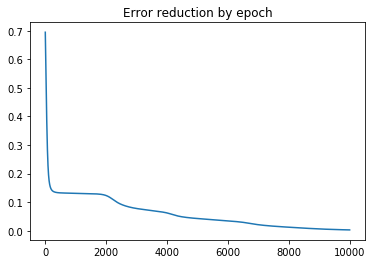

In [31]:
plt.plot(H.history['loss'])
plt.title("Error reduction by epoch")

### Model to generate array containing item representations for each input

## Sub-models for recording activation states

Often we want to record the internal representations and outputs generated by various inputs as the model trains, or when it is trained. One way to do this is to build sub-models from the components of the main model, using the same input layer but specifying the layer one wishes to record as the output layer. (Maybe there is a more convenient way to do this). This block will create sub-models to record activation patterns from the _Representation_ and _Hidden_ layers.

In [38]:
#Sub-model used for recording item representations
itemrep = Model(inputs = rumext.inputs, outputs = rumext.layers[1].output)

#Sub-model used for recording item-in-context representations
hidrep = Model(inputs=rumext.inputs, outputs=rumext.layers[4].output)

To look at hidden representation structure, can build a new sub-model model from pieces of existing, trained model, using the hidden representation layer as the output layer. This model can then be used to generate hidden rep output activations using its predict method, applied to the patterns in the training corpus.

In [33]:
irep  = itemrep.predict([item_in_pats[0:21,:], query_in_pats[0:21,:]])

Using the clustering functions fromthe scipy library, we can generate a cluster plot to visualize these representations.

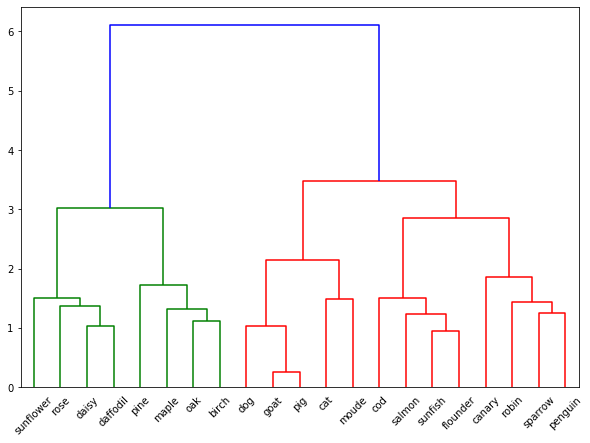

In [34]:
plt.figure(figsize=(10,7))
dend = shc.dendrogram(shc.linkage(irep, method='ward'), labels=inames)

In [37]:
np.savetxt('RumextResults/rumext_final_ireps.csv', irep, delimiter=',')

In [39]:
iicreps =hidrep.predict([item_in_pats, query_in_pats])

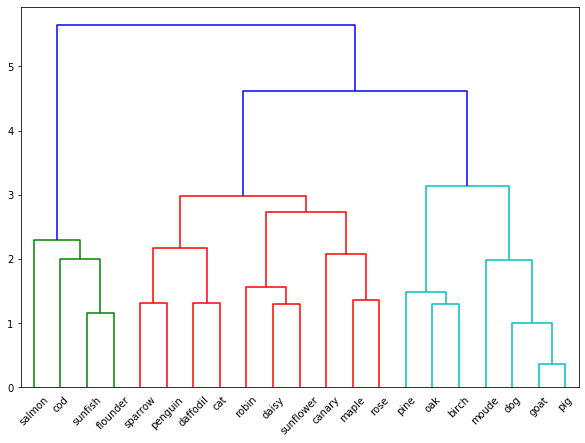

In [54]:
plt.figure(figsize=(10,7))
dend = shc.dendrogram(shc.linkage(iicreps[np.arange(0,21)+21*3,], method='ward'), labels=inames)

In [55]:
np.savetxt('RumextResults/rumext_final_iicreps.csv', iicreps, delimiter=',')